# LaQuacco 🍅🍅🍅

## Laboratory Quality Control

### Module Imports

In [1]:
import os
import platform
import sys
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import laquacco as laq  # custom functions

### User Input

In [11]:
# define search pattern for positive controls (if available)
control_dir = r"./tests/Polaris"
control_ext = "*.tif"
#control_dir = r"./tests/Leidos"
#control_ext = "*Tonsil*.qptiff"
#control_dir = r"./tests/MIBI"
#control_ext = "*.tif"
control_exc = ""
control_sub = True

# define search pattern for QC samples
sample_dir = r"./tests/Polaris"
sample_ext = "*.tif"
#sample_dir = r"./tests/Leidos"
#sample_ext = "*.qptiff"
#sample_dir= r"./tests/MIBI"
#sample_ext = "*.tif"
sample_exc = ""
sample_sub = True

# output settings
sort_chans = False  # sort alphabetically

# render channel images of outliers
show_img = False

### Check samples

In [3]:
# list positive controls
controls = sorted(
    laq.get_files(
        path=control_dir,
        pat=control_ext,
        anti=control_exc,
        recurse=control_sub,
    ),
    key=str.lower,
)
controls_len = len(controls)
print(f"Found {controls_len} controls in {os.path.abspath(control_dir)}:")
for control in controls:
    print(f"{control.replace(control_dir, '.')}")
print()

# list samples
samples = sorted(
    laq.get_files(
        path=sample_dir,
        pat=sample_ext,
        anti=sample_exc,
        recurse=sample_sub,
    ),
    key=str.lower,
)
samples_len = len(samples)
print(f"Found {samples_len} samples in {os.path.abspath(sample_dir)}:")
for sample in samples:
    print(f"{sample.replace(sample_dir, '.')}")

Found 7 controls in /Users/christianrickert/Documents/GitHub/LaQuacco/tests/Polaris:
./100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif
./100923 P9huP54-2 #02 B2A2P1_[9154,44215]_component_data.tif
./100923 P9huP54-2 #03 B2A3P1_[9291,42377]_component_data.tif
./100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif
./111623 P9huP54-2 #01 B2A1P1_[10735,46340]_component_data.tif
./111623 P9huP54-2 #02 B2A2P1_[9705,46673]_component_data.tif
./111623 P9huP54-2 #03 B2A3P1_[10517,47084]_component_data.tif

Found 7 samples in /Users/christianrickert/Documents/GitHub/LaQuacco/tests/Polaris:
./100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif
./100923 P9huP54-2 #02 B2A2P1_[9154,44215]_component_data.tif
./100923 P9huP54-2 #03 B2A3P1_[9291,42377]_component_data.tif
./100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif
./111623 P9huP54-2 #01 B2A1P1_[10735,46340]_component_data.tif
./111623 P9huP54-2 #02 B2A2P1_[9705,46673]_component_data.tif
./111623 P9huP54-2 #0

### Sample Data

In [10]:
# get control statistics
controls_img_data = {}
start = time.time()
for count, control in enumerate(controls, start=1):
    print(f"CONTROL: [{count}/{controls_len}]  {os.path.basename(control)}", end="", flush=True)
    controls_img_data[control] = laq.stats_img_data(laq.get_tiff(control))  # signal above zero
    print(f"  (-{laq.get_time_left(start, count, controls_len)})", flush=True)
print()

# prepare dictionary (set) of unique channel labels
chans = dict()  # dictionary retains insertion order
for img_data in controls_img_data.values():
    for chan in img_data:
        if chan not in ["metadata"]:
            chans[chan] = None
chans = list(chans.keys())
if sort_chans:
    chans = sorted(chans, key=str.lower)

# prepare bottom and top percentiles for analysis
chans_min = {chan: np.nan for chan in chans}
chans_max = {chan: np.nan for chan in chans}
chans_minmax = {chan: (np.nan, np.nan) for chan in chans}
for chan in chans:
    print(f"{chan}:", flush=True)
    minmax = laq.get_chan_data(controls_img_data, chan, "minmax")
    chans_minmax[chan] = (np.mean(minmax[:, 0]), np.mean(minmax[:, 1]))
    print(
        f"\tMaximum: {chans_minmax[chan][1]:7.1f} (mean), {np.std(minmax[:, 1]):7.1f} (std)\n",
        f"\tMinimum: {chans_minmax[chan][0]:7.1f} (mean), {np.std(minmax[:, 0]):7.1f} (std)\n",
    )

# get sample statistics
samples_img_data = {}
start = time.time()
for count, sample in enumerate(samples, start=1):
    print(f"SAMPLE: [{count}/{samples_len}]  {os.path.basename(sample)}", end="", flush=True)
    samples_img_data[sample] = laq.stats_img_data(laq.get_tiff(sample), chans_minmax)
    print(f"  (-{laq.get_time_left(start, count, samples_len)})", flush=True)
print()

# sort sample image data and list by time stamp
samples_img_data = dict(
    sorted(samples_img_data.items(), key=lambda v: v[1]["metadata"]["date_time"])
)
samples = [sample for sample in samples_img_data.keys()]

CONTROL: [1/7]  100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif  (-1s)
CONTROL: [2/7]  100923 P9huP54-2 #02 B2A2P1_[9154,44215]_component_data.tif  (-1s)
CONTROL: [3/7]  100923 P9huP54-2 #03 B2A3P1_[9291,42377]_component_data.tif  (-0s)
CONTROL: [4/7]  100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif  (-0s)
CONTROL: [5/7]  111623 P9huP54-2 #01 B2A1P1_[10735,46340]_component_data.tif  (-0s)
CONTROL: [6/7]  111623 P9huP54-2 #02 B2A2P1_[9705,46673]_component_data.tif  (-0s)
CONTROL: [7/7]  111623 P9huP54-2 #03 B2A3P1_[10517,47084]_component_data.tif  (-0s)

CD68 (Opal 480):
	Maximum:    67.5 (mean),     5.7 (std)
 	Minimum:     0.1 (mean),     0.1 (std)

CD8 (Opal 520):
	Maximum:    19.4 (mean),     5.5 (std)
 	Minimum:     0.0 (mean),     0.0 (std)

CD4 (Opal 540):
	Maximum:    34.1 (mean),     1.8 (std)
 	Minimum:     0.0 (mean),     0.0 (std)

CD56 (Opal 570):
	Maximum:    16.6 (mean),     4.1 (std)
 	Minimum:     0.0 (mean),     0.0 (std)

CD3 (Opal 620):
	Maxim

### Graphics Settings

In [5]:
# prepare figure dimensions
dpi = plt.rcParams["figure.dpi"]
min_pixw, min_pixh = 1600, 1200
min_width, min_height = min_pixw / dpi, min_pixh / dpi
plt.rcParams["figure.figsize"] = [min_width, min_height]

### Data Plots I - Distribution Chart

Plotting distribution chart...



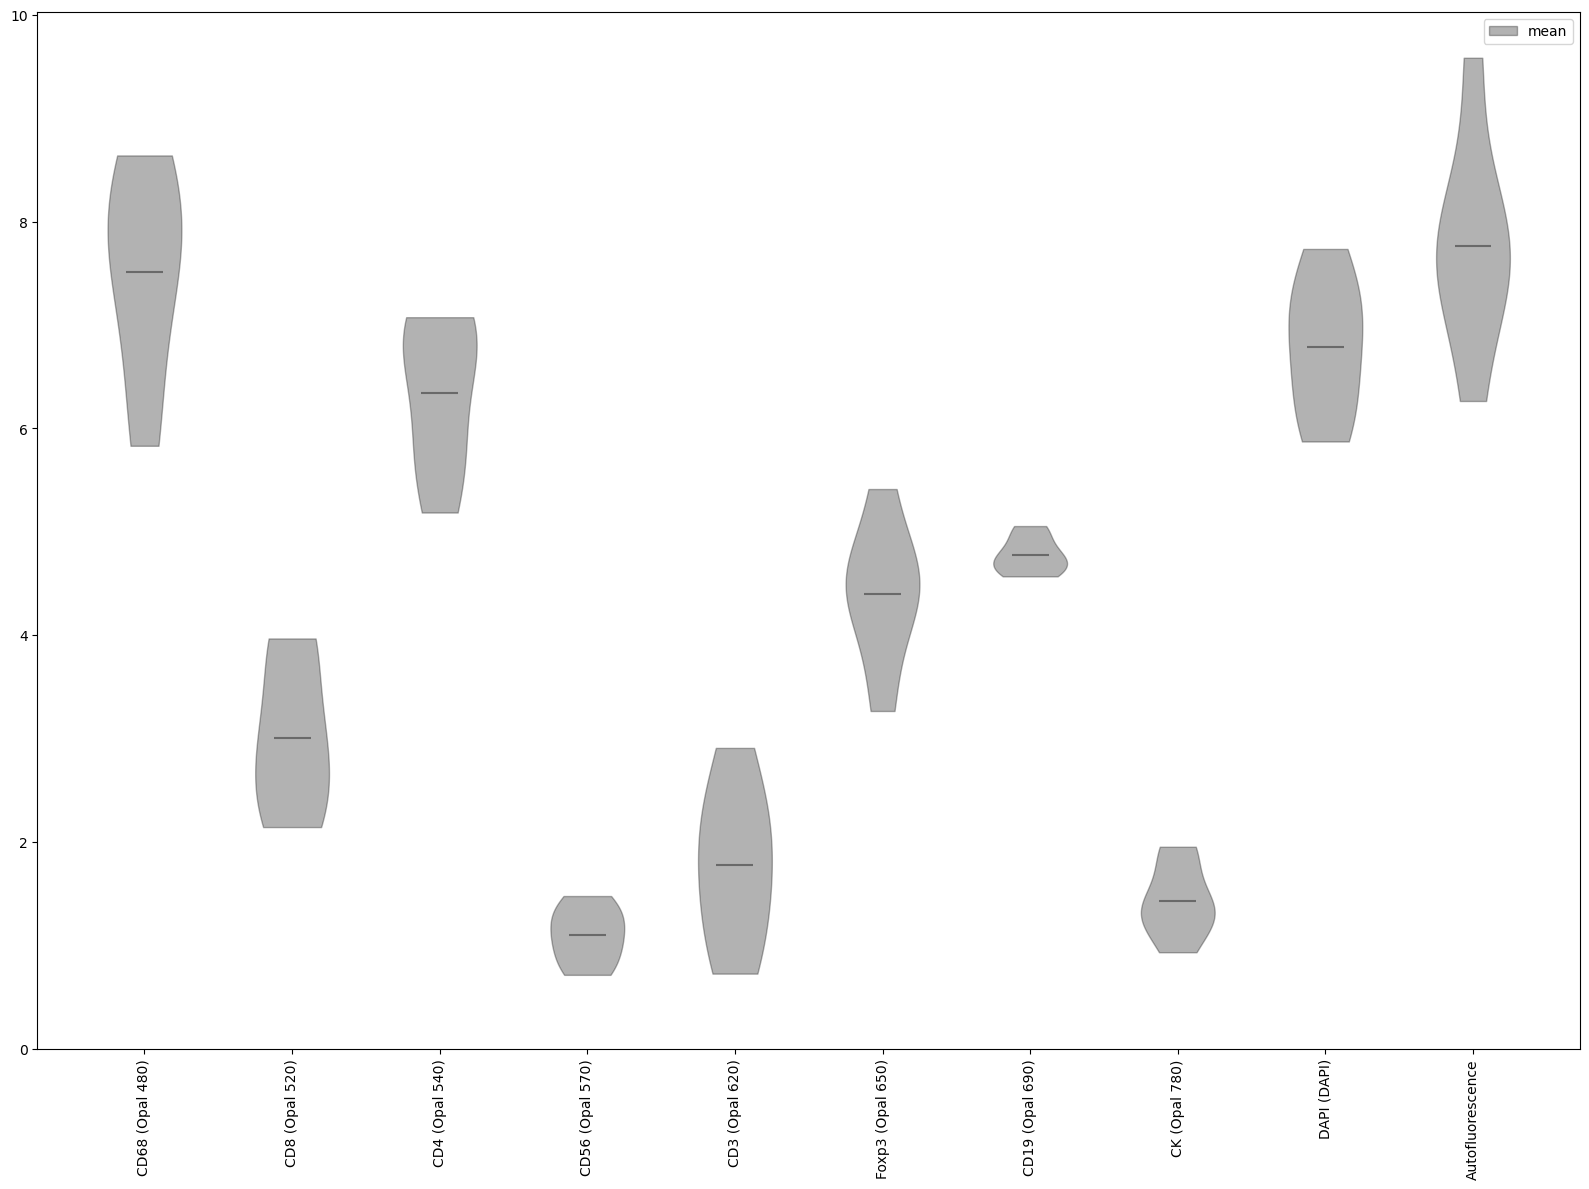

In [6]:
print("Plotting distribution chart...\n", flush=True)

# get mean data for plots
means = []
fig, ax = plt.subplots()
for c, chan in enumerate(chans):
    means.append(laq.get_chan_data(samples_img_data, chan, "mean"))

# create violin plot
vp = ax.violinplot(means, showmeans=True, showextrema=False)
for p in vp["bodies"]:
    p.set_facecolor("black")
    p.set_edgecolor("black")
for l in ["cmeans"]:
    vp[l].set_edgecolor("dimgray")

# adjust axes
ax.set_xticks([c for c in range(1, len(chans) + 1)], labels=chans, rotation=90)
plt.ylim(bottom=0.0)

# add legend
legend = plt.legend(
    [vp["bodies"][0]],
    ["mean"],
)

# show plot
plt.tight_layout()
plt.show()

### Data Plots II - Levey-Jennings Charts

Plotting Levey-Jennings charts...

1 = 100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif
2 = 100923 P9huP54-2 #02 B2A2P1_[9154,44215]_component_data.tif
3 = 100923 P9huP54-2 #03 B2A3P1_[9291,42377]_component_data.tif
4 = 100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif
5 = 111623 P9huP54-2 #01 B2A1P1_[10735,46340]_component_data.tif
6 = 111623 P9huP54-2 #02 B2A2P1_[9705,46673]_component_data.tif
7 = 111623 P9huP54-2 #03 B2A3P1_[10517,47084]_component_data.tif



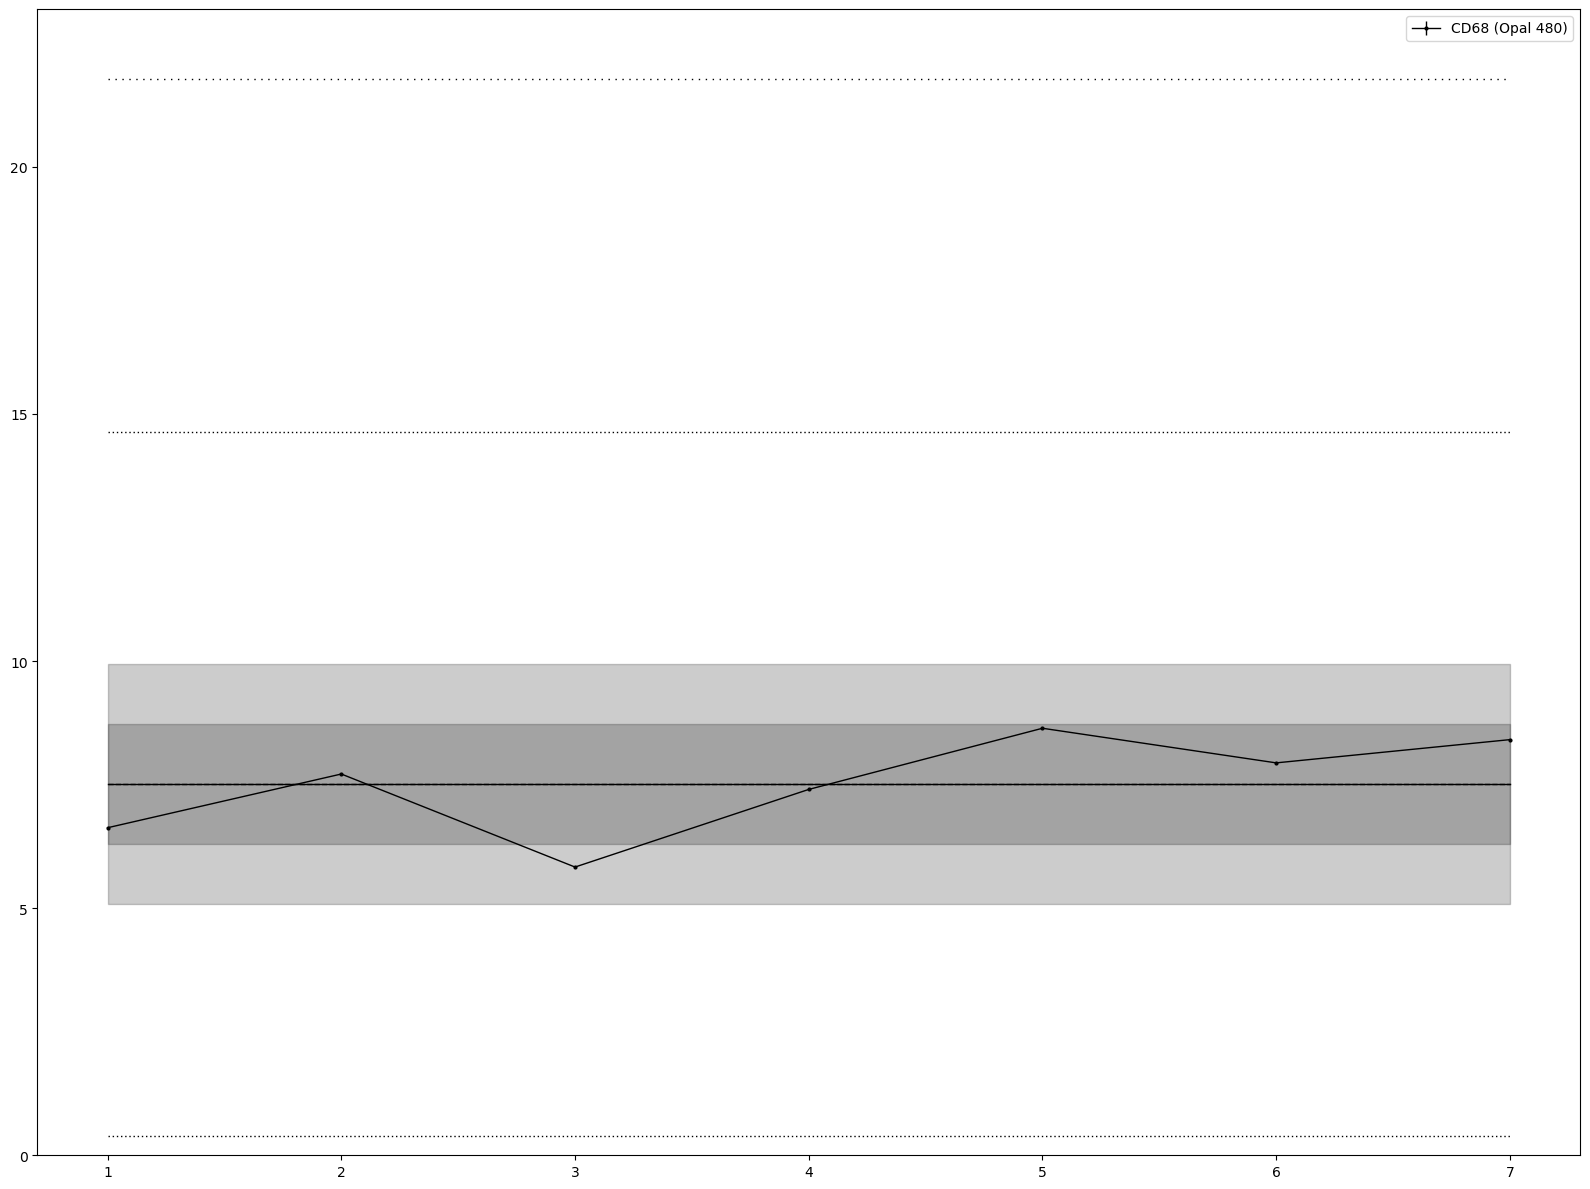

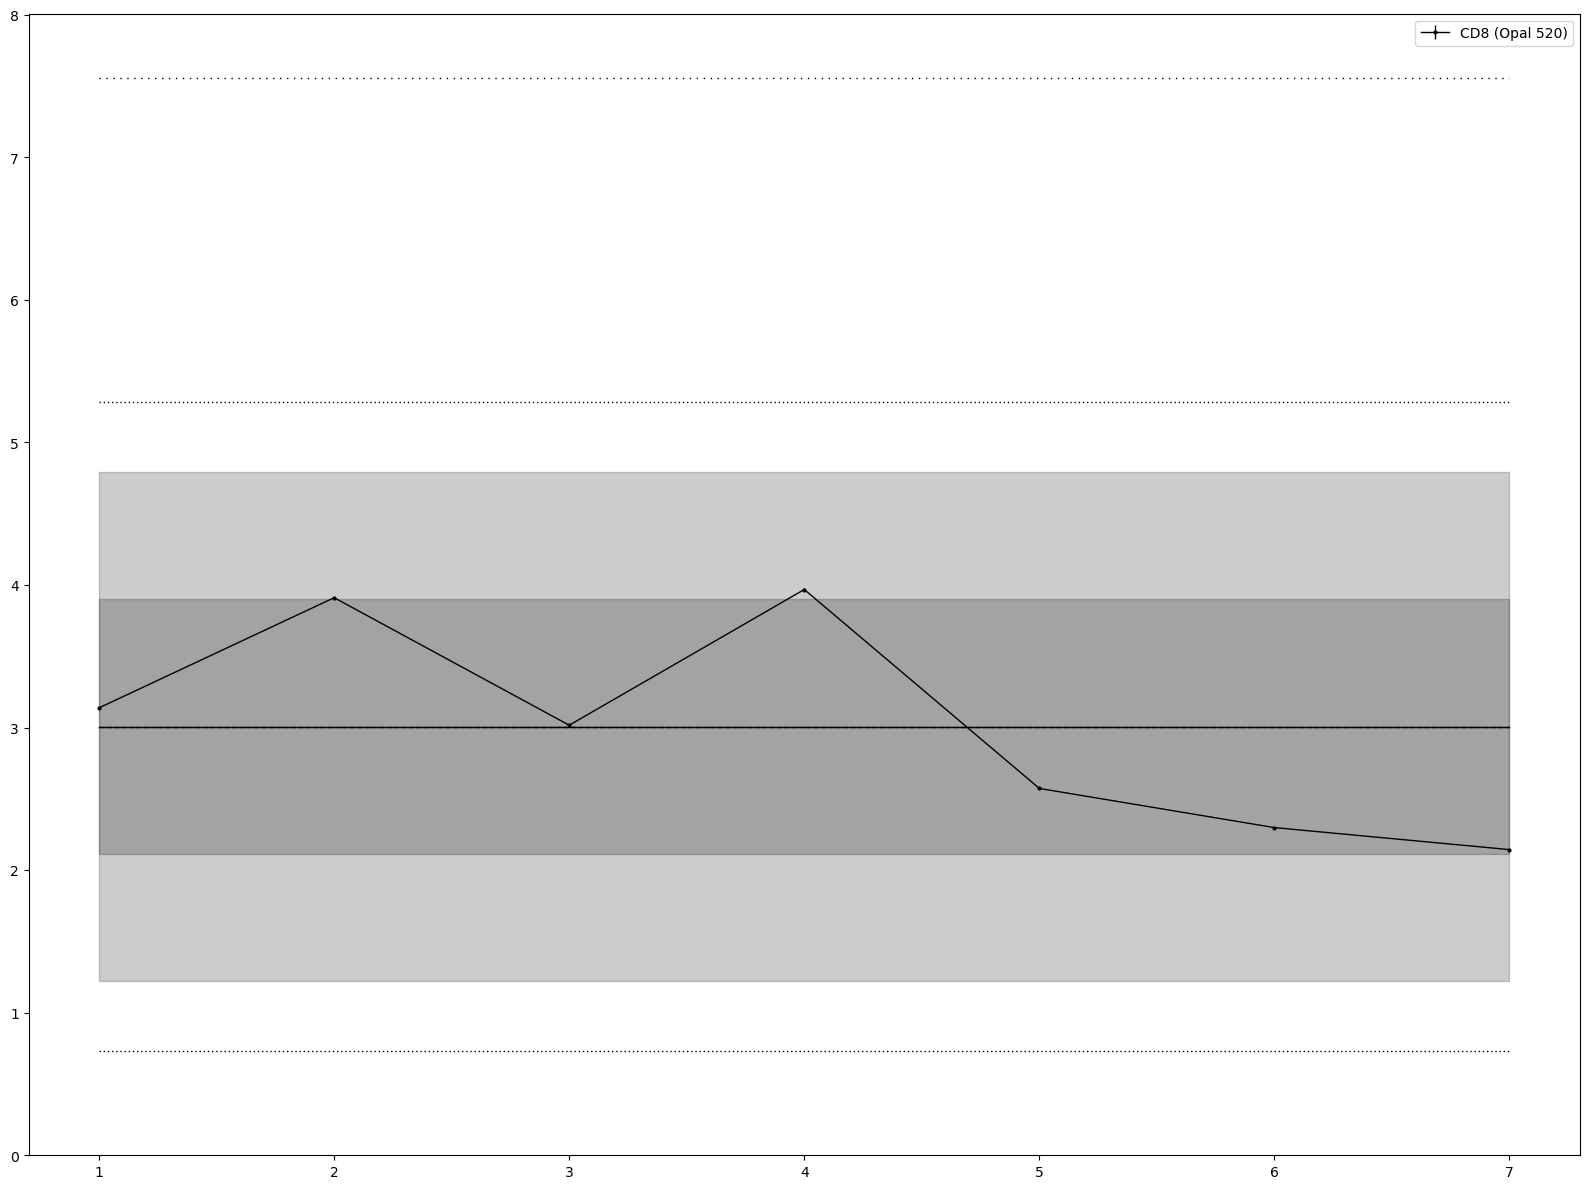

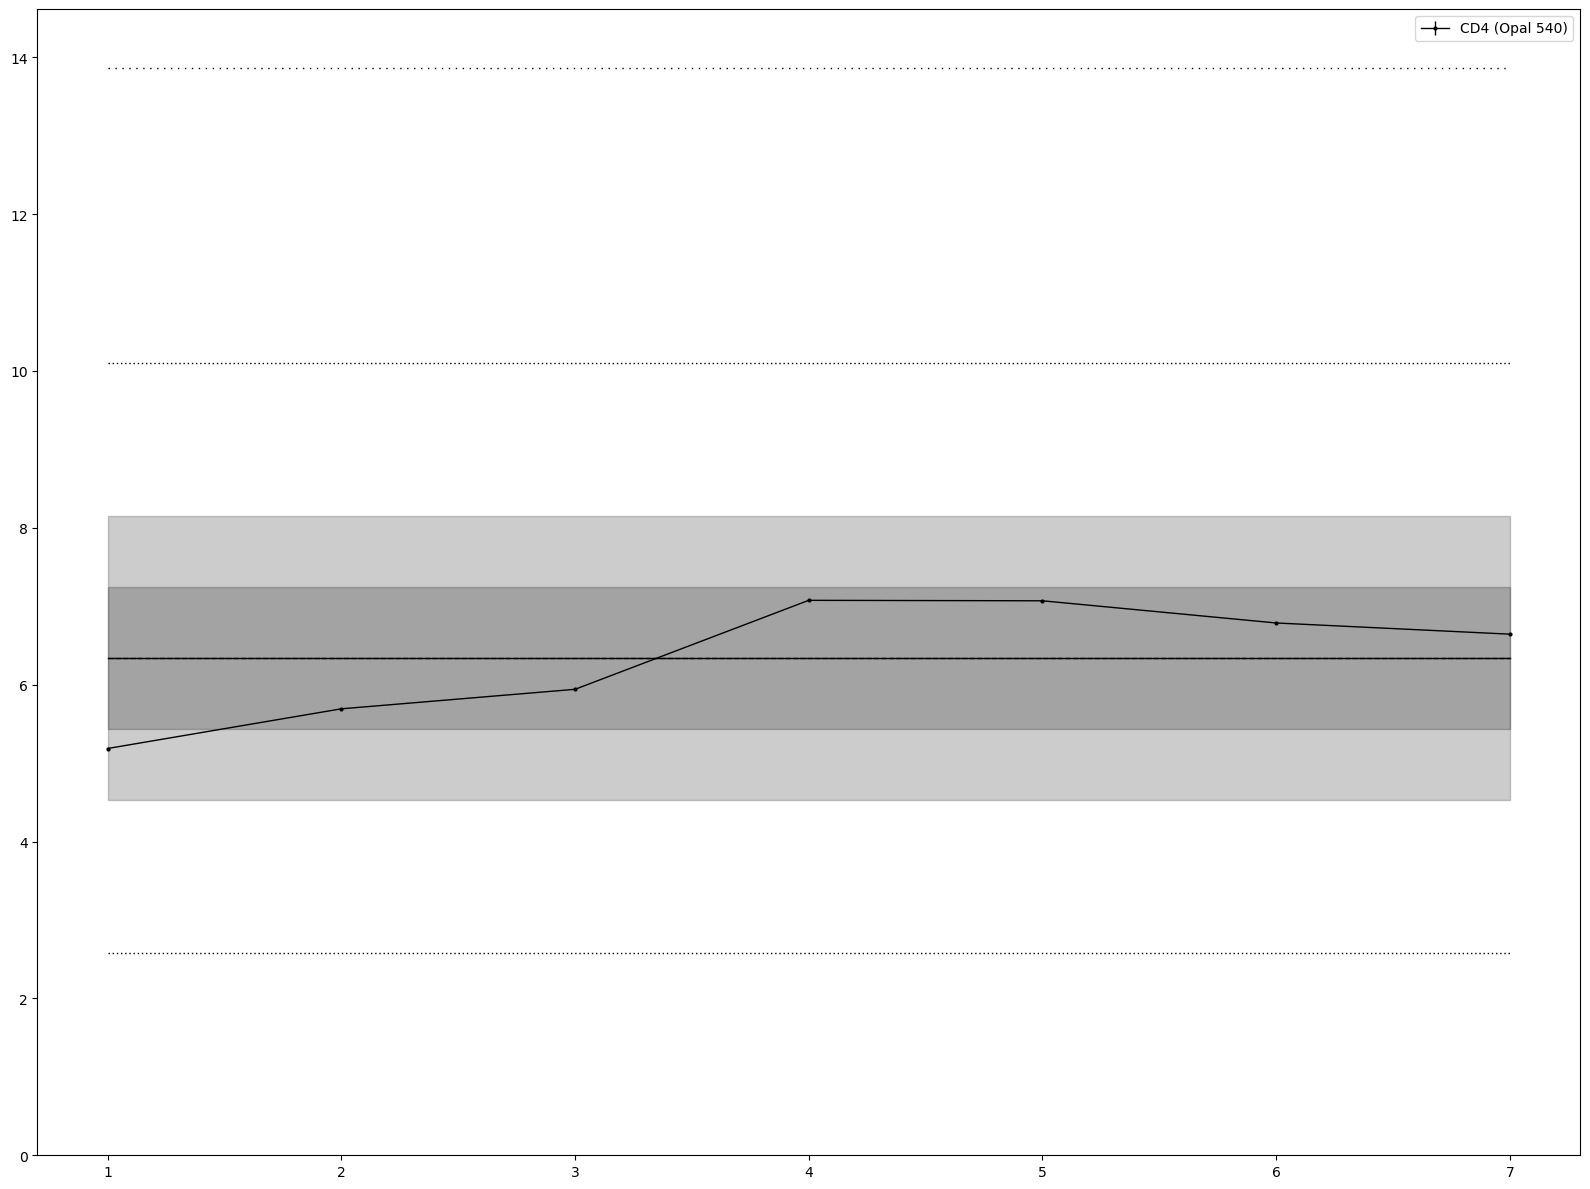

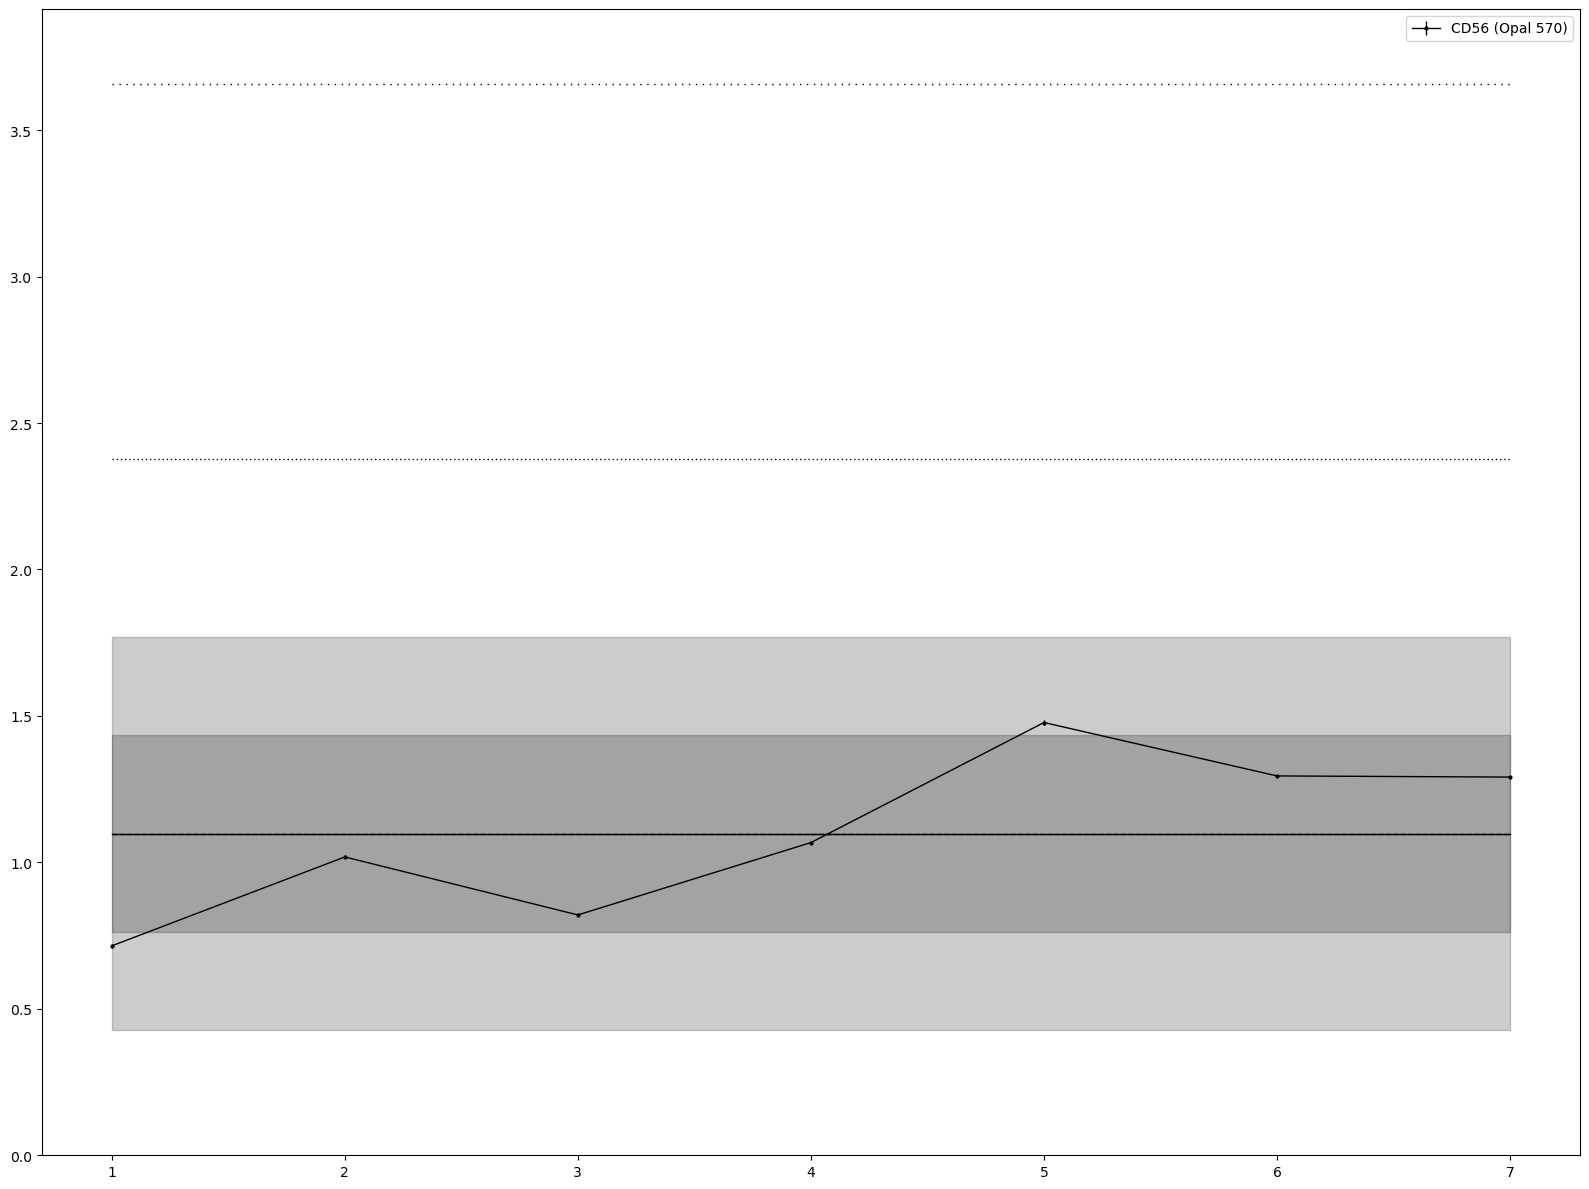

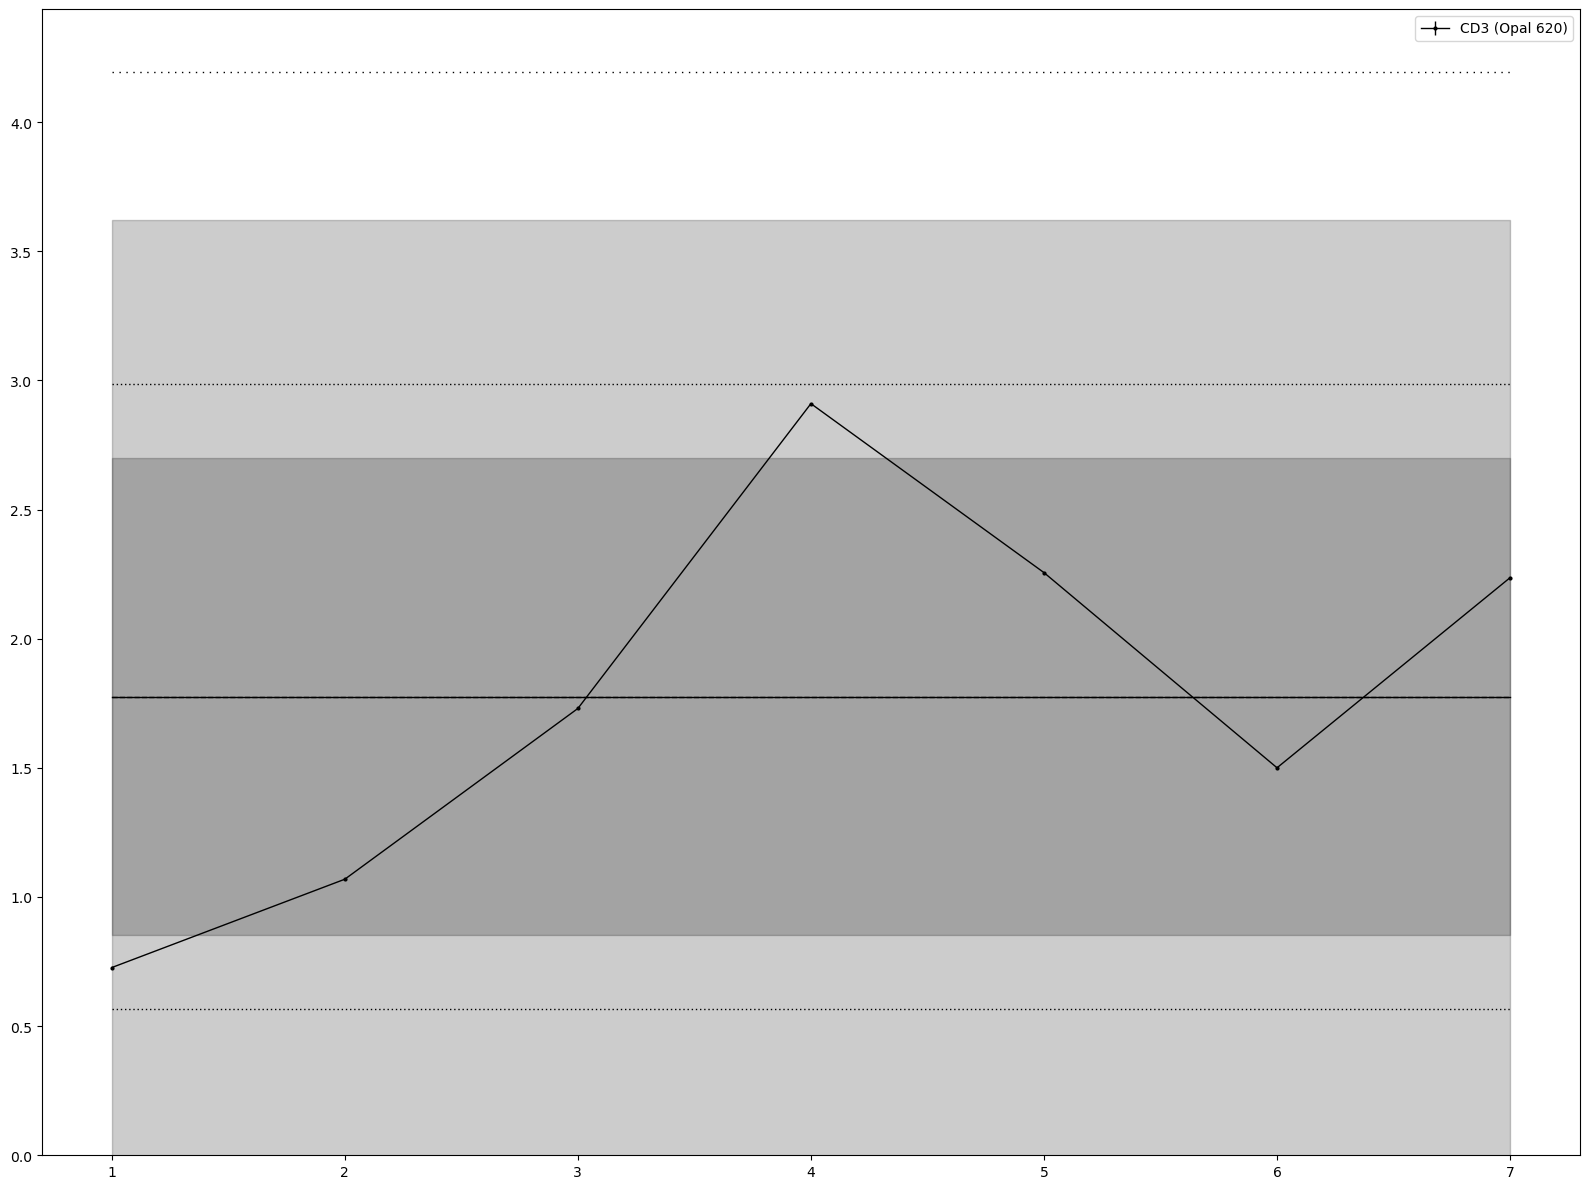

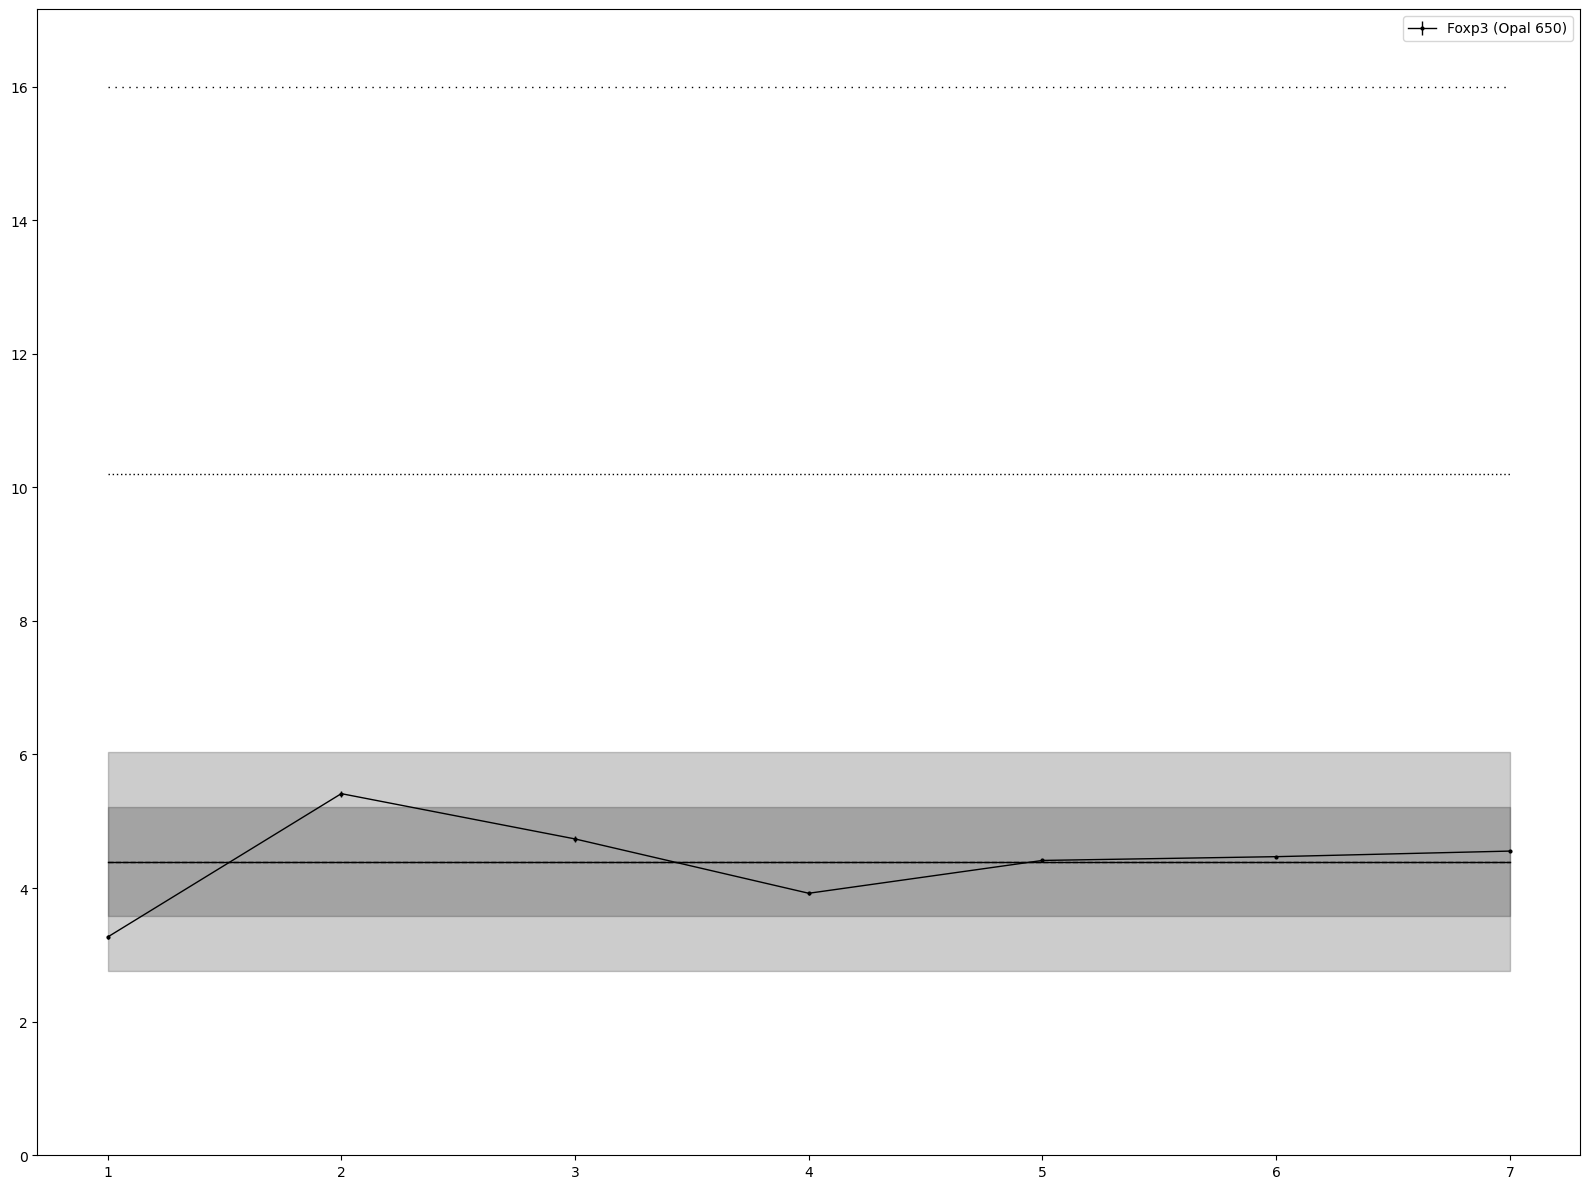

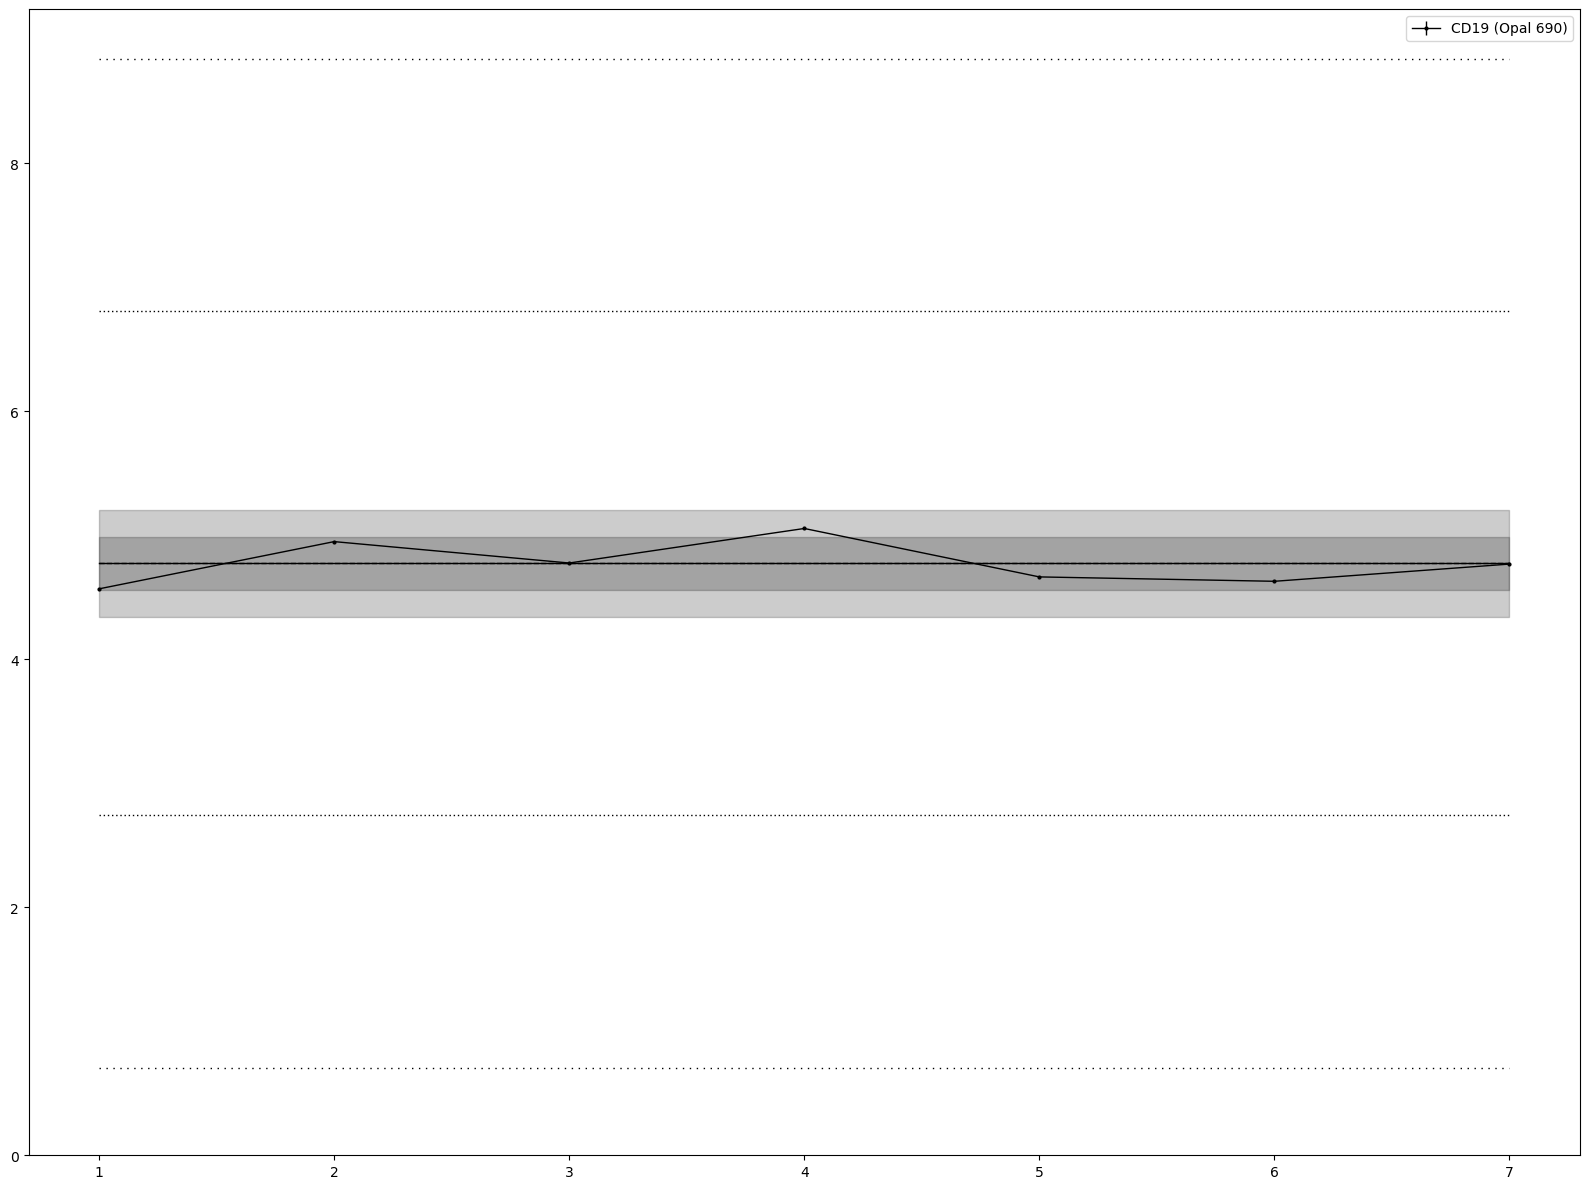

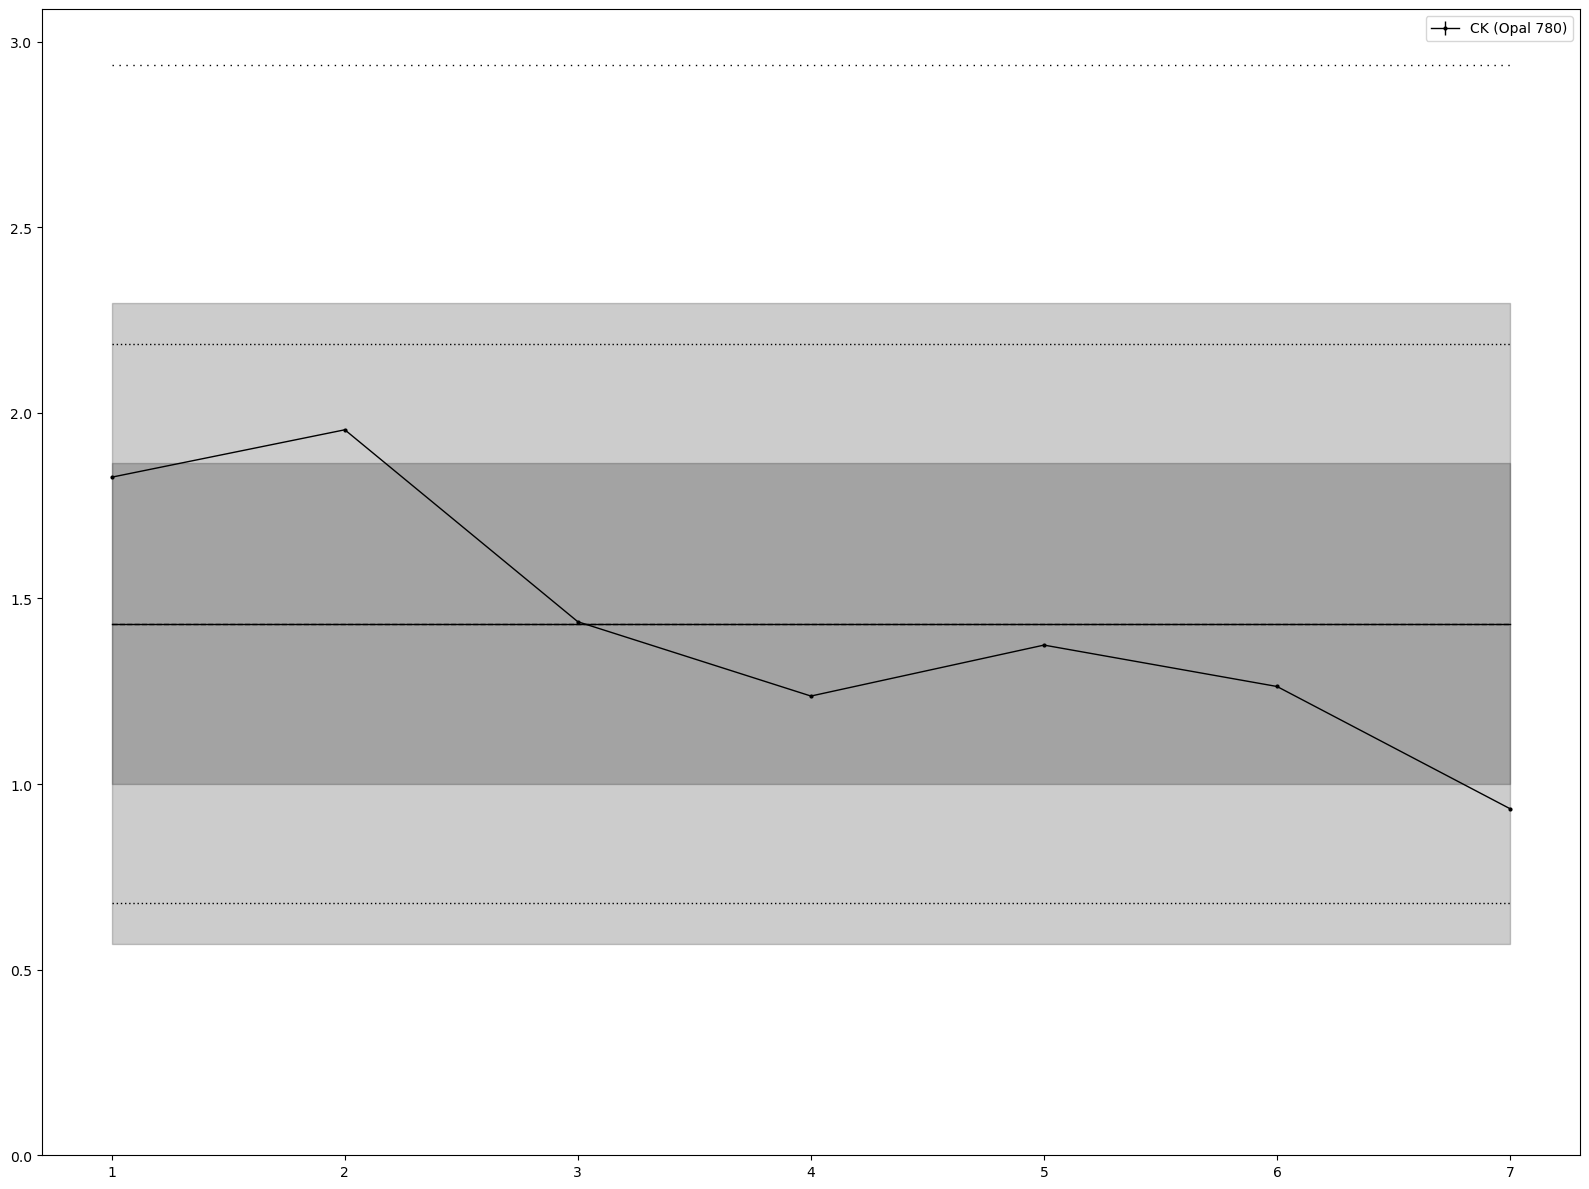

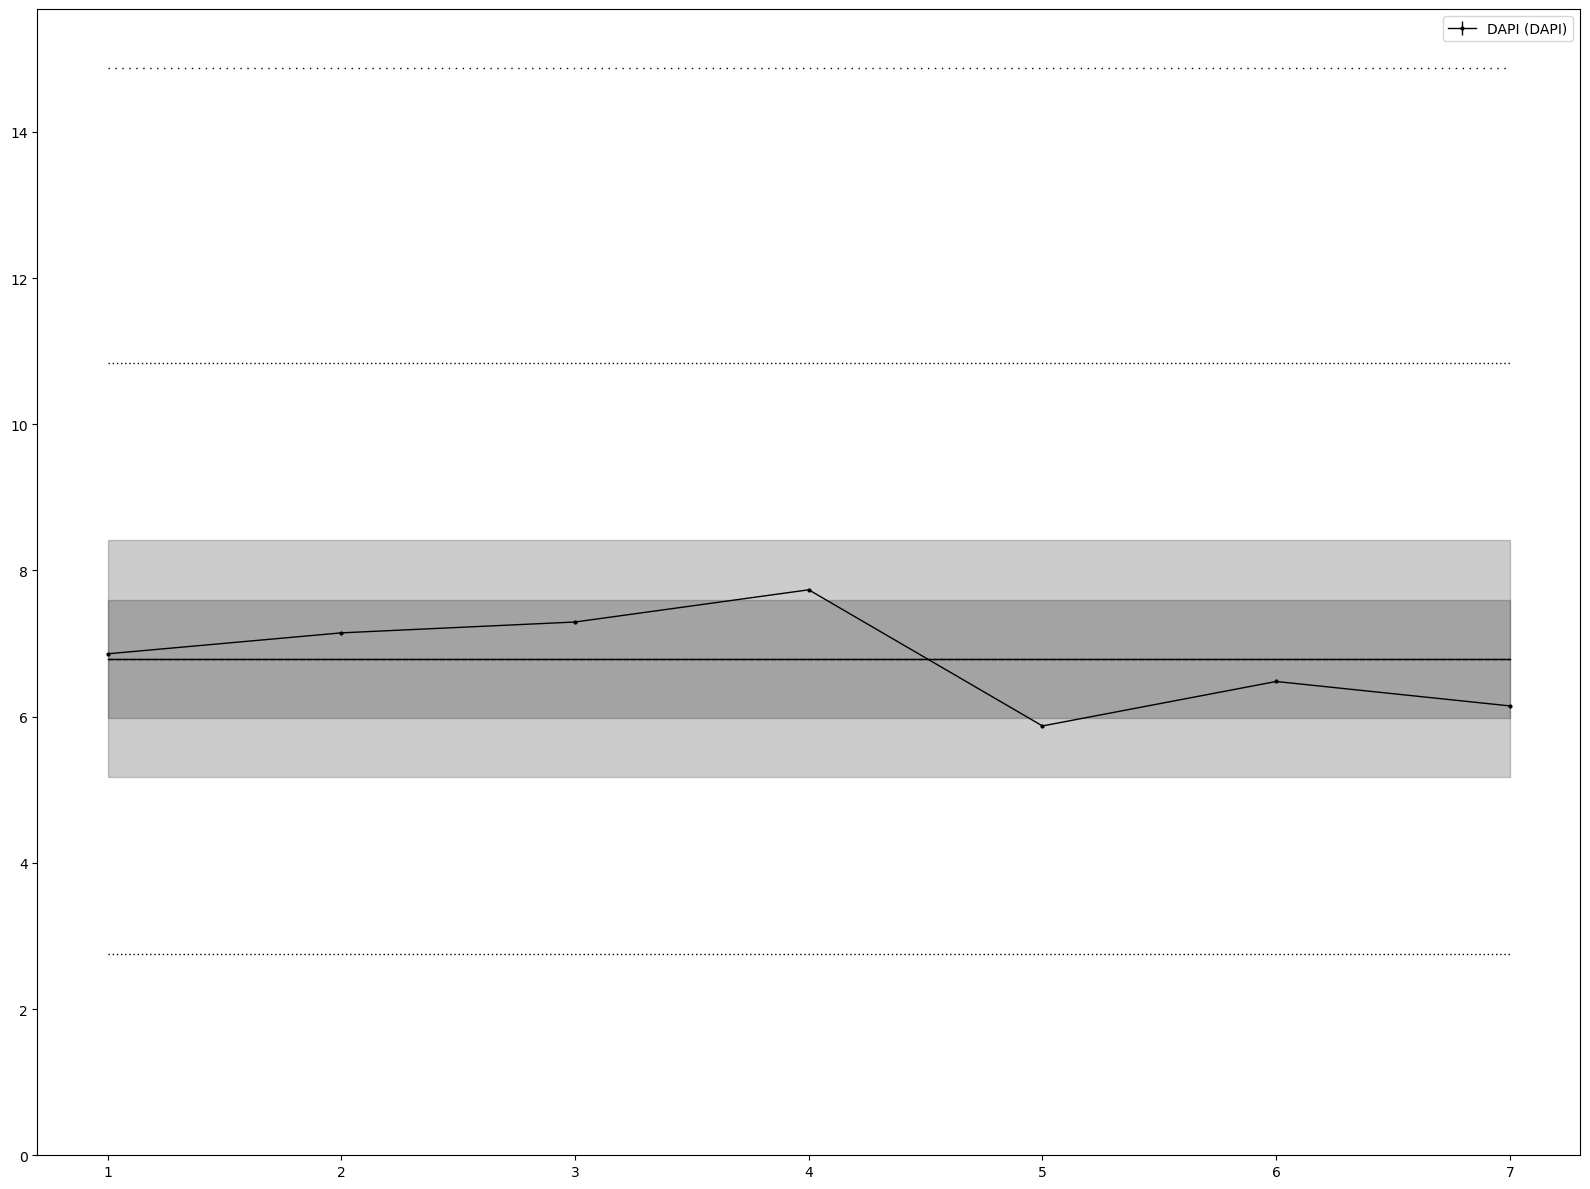

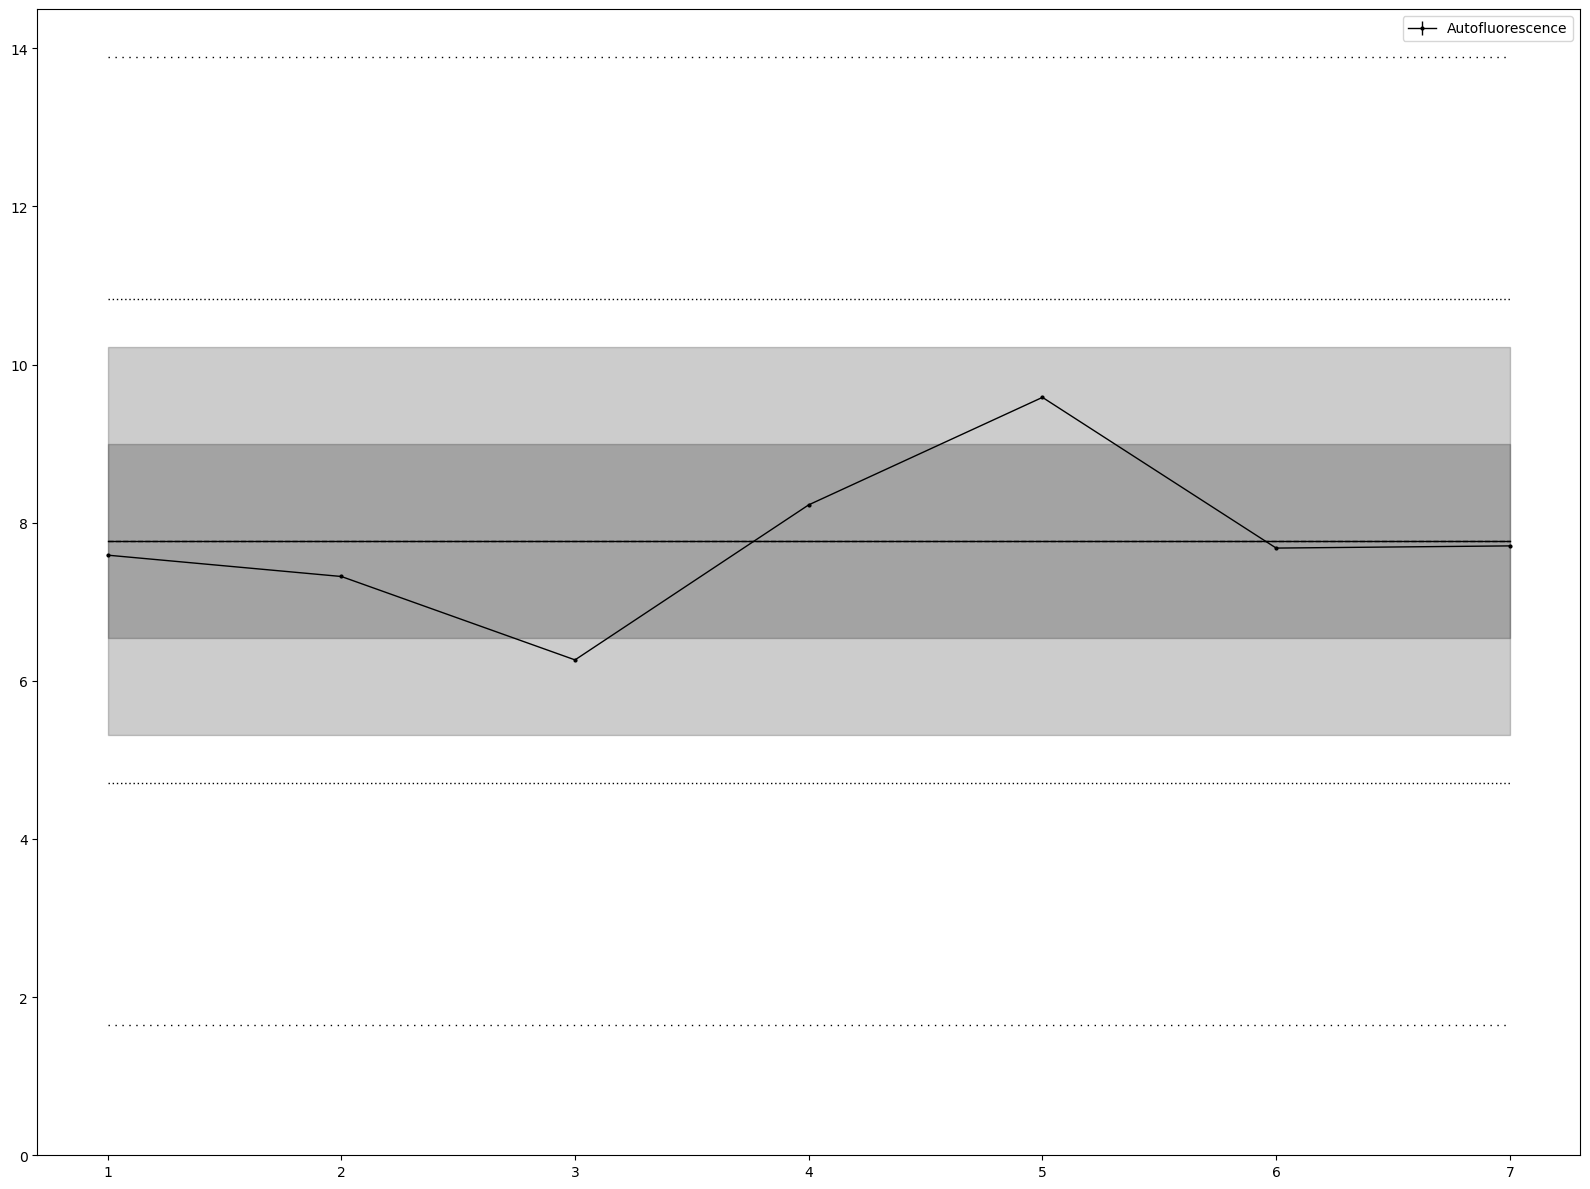

In [7]:
print("Plotting Levey-Jennings charts...\n", flush=True)

# positions in plot
for position, sample in enumerate(samples, 1):
    print(f"{position} = {os.path.basename(sample)}")
print()

# prepare variables
slice_ext = samples_len - 1  # extend slice to either sides
fit_trend = False  # fit a linear regression model of the mean
slice_size = min(samples_len, 2 * slice_ext + 1)
assert (
    slice_size > 3
), "Zero degrees of freedom to estimate the standard deviation from the trend line."
chan_means = {}
chan_extras = {}
x_vals = range(1, samples_len + 1)
np_nan = np.full(samples_len, np.nan)

# create error bar plots
for c, chan in enumerate(chans):
    # prepare variables
    run = {stat: np_nan.copy() for stat in ["slice", "means", "stdevs"]}
    trend = {stat: np_nan.copy() for stat in ["slice", "vals", "stdevs"]}

    # get image statistics
    means = laq.get_chan_data(samples_img_data, chan, "mean")
    stdevs = laq.get_chan_data(samples_img_data, chan, "stdev")
    stderrs = laq.get_chan_data(samples_img_data, chan, "stderr")
    chan_means[chan] = means

    # get trend statistics
    if fit_trend:
        slope, inter = np.polyfit(x_vals, means, deg=1)
        trend["vals"] = slope * x_vals + inter
    else:
        trend["vals"].fill(np.nanmean(means))

    # get running statistics
    for i, mean in enumerate(means):
        run["slice"] = laq.get_run_slice(means, i, slice_ext)
        if run["slice"].size == slice_size:
            run["means"][i] = np.nanmean(run["slice"])
            run["stdevs"][i] = np.nanmean(laq.get_run_slice(stdevs, i, slice_ext))
            trend["slice"] = laq.get_run_slice(trend["vals"], i, slice_ext)
            trend["stdevs"][i] = np.nanstd(run["slice"], ddof=3)  # estimated: slope, intercept, and mean

    # get extrema from trend line
    chan_extras_keys = [("p2stdev", "m2stdev"), ("p1stdev", "m1stdev")]
    chan_extras[chan] = {
        chan_extras_keys[0][0]: trend["vals"] + 2.0 * trend["stdevs"],
        chan_extras_keys[1][0]: trend["vals"] + 1.0 * trend["stdevs"],
        chan_extras_keys[1][1]: trend["vals"] - 1.0 * trend["stdevs"],
        chan_extras_keys[0][1]: trend["vals"] - 2.0 * trend["stdevs"],
    }

    # plot statistics
    for dist in [2.0, 1.0, -1.0, -2.0]:
        linestyle = (0, (1, 2))
        if abs(dist) == 2.0:
            linestyle = linestyle = (0, (1, 4))
        plt.plot(
            x_vals,
            run["means"] + dist * run["stdevs"],
            color="black",
            linewidth=1,
            linestyle=linestyle,
        )
    for upper, lower in chan_extras_keys:
        plt.fill_between(
            x_vals,
            chan_extras[chan][upper],
            chan_extras[chan][lower],
            color="black",
            alpha=0.2,
        )
    plt.plot(x_vals, trend["vals"], color="black", linewidth=1, linestyle="solid")
    plt.plot(x_vals, run["means"], color="black", linewidth=1, linestyle="dashed")

    # plot y values with errors
    plt.errorbar(
        x_vals,
        means,
        yerr=stderrs,
        fmt="o-",
        linewidth=1,
        markersize=2,
        color="black",
        label=chan,
    )

    # adjust axes
    plt.ylim(0.0)

    # add legend
    legend = plt.legend()

    # show plot
    plt.tight_layout()
    plt.show()

### Data Plots II - Extreme Values


CD68 (Opal 480):


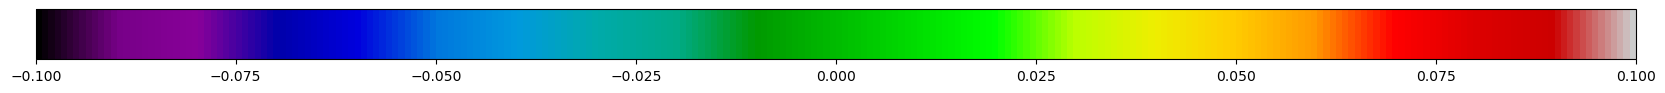


	▼   2 = 100923 P9huP54-2 #03 B2A3P1_[9291,42377]_component_data.tif

CD8 (Opal 520):


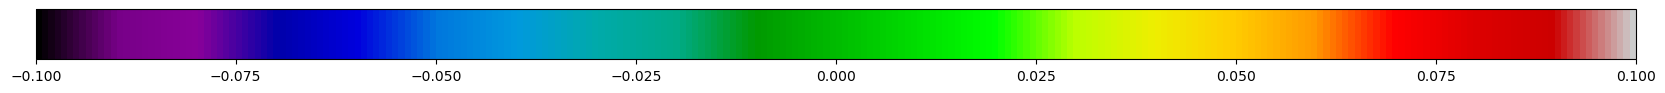


	▲   1 = 100923 P9huP54-2 #02 B2A2P1_[9154,44215]_component_data.tif

	▲   3 = 100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif

CD4 (Opal 540):


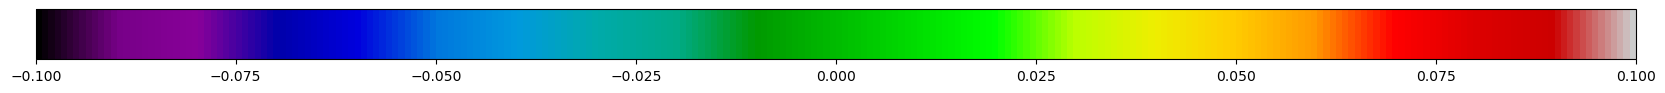


	▼   0 = 100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif

CD56 (Opal 570):


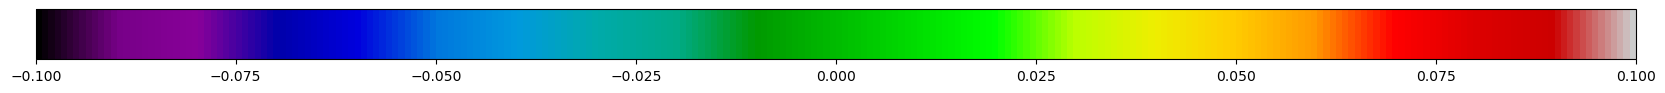


	▼   0 = 100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif

	▲   4 = 111623 P9huP54-2 #01 B2A1P1_[10735,46340]_component_data.tif

CD3 (Opal 620):


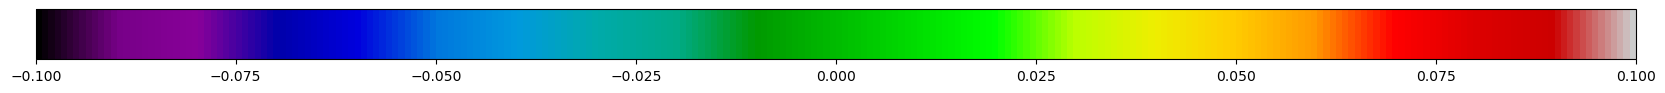


	▼   0 = 100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif

	▲   3 = 100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif

Foxp3 (Opal 650):


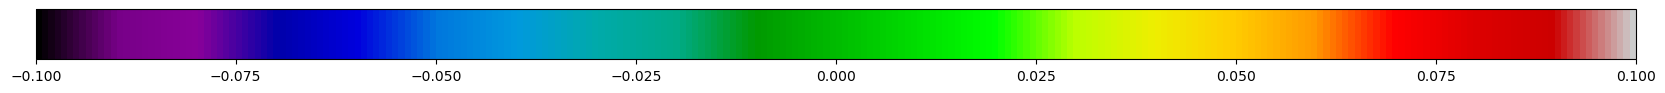


	▼   0 = 100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif

	▲   1 = 100923 P9huP54-2 #02 B2A2P1_[9154,44215]_component_data.tif

CD19 (Opal 690):


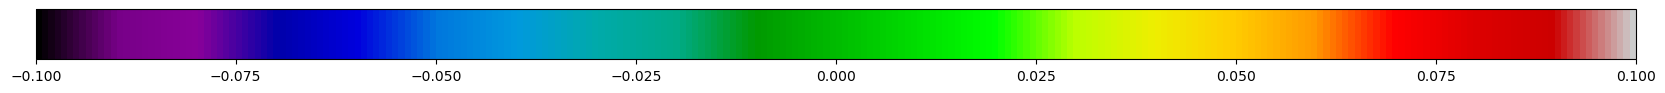


	▲   3 = 100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif

CK (Opal 780):


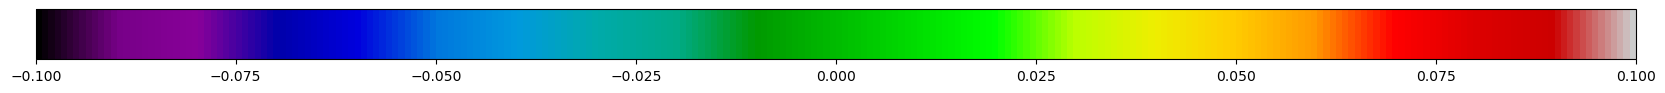


	▲   1 = 100923 P9huP54-2 #02 B2A2P1_[9154,44215]_component_data.tif

	▼   6 = 111623 P9huP54-2 #03 B2A3P1_[10517,47084]_component_data.tif

DAPI (DAPI):


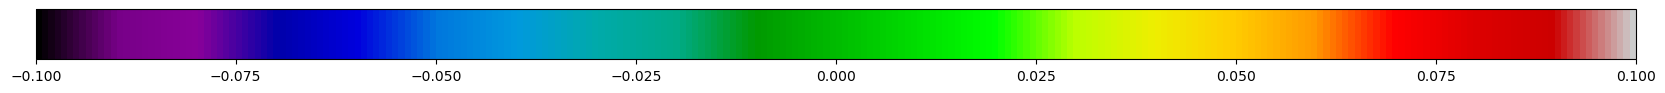


	▲   3 = 100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif

	▼   4 = 111623 P9huP54-2 #01 B2A1P1_[10735,46340]_component_data.tif

Autofluorescence:


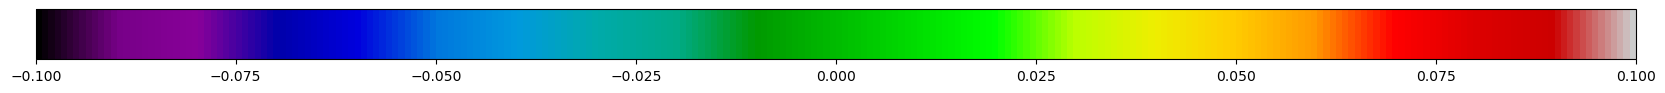


	▼   2 = 100923 P9huP54-2 #03 B2A3P1_[9291,42377]_component_data.tif

	▲   4 = 111623 P9huP54-2 #01 B2A1P1_[10735,46340]_component_data.tif


In [8]:
# list all images with extreme values per channel
for c, chan in enumerate(chans):
    print(f"\n{chan}:", flush=True)
    outliers = []
    for m, mean in enumerate(chan_means[chan]):
        if mean > chan_extras[chan]["p2stdev"][m]:
            outliers.append(("▲▲ ", m, samples[m], chan, mean))
        elif mean > chan_extras[chan]["p1stdev"][m]:
            outliers.append(("▲  ", m, samples[m], chan, mean))
        elif mean < chan_extras[chan]["m2stdev"][m]:
            outliers.append(("▼▼ ", m, samples[m], chan, mean))
        elif mean < chan_extras[chan]["m1stdev"][m]:
            outliers.append(("▼  ", m, samples[m], chan, mean))
    # show color bar at top
    cmap = mpl.cm.nipy_spectral
    norm = mpl.colors.Normalize(
        vmin=np.median(chans_min[chan]), vmax=np.median(chans_max[chan])
    )
    scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    scalarmappable.set_array([])
    fig = plt.figure(figsize=(min_width, 1))
    ax = fig.add_axes([0.0, 0.0, 1, 0.5])
    cbar = fig.colorbar(scalarmappable, cax=ax, orientation="horizontal")
    plt.show()
    if outliers:
        # print list of outliers with optional channel images
        for indicator, position, sample, channel, mean in outliers:
            print(
                f"\n\t{indicator} {position} = {os.path.basename(sample)}"
                # f"  ({mean}) [{chans_minmax[chan][0]}-{chans_minmax[chan][1]}]"
            )
            if show_img:
                plt.imshow(
                    laq.get_chan_img(sample, channel),
                    cmap="nipy_spectral",
                    vmin=chans_min[chan],
                    vmax=chans_max[chan],
                    resample=False,
                )
                plt.show()
    else:
        print(f"\t►  (none)")

### Data Plots III - C-Score Charts

In [9]:
print("Plotting C-Score charts...\n", flush=True)

# positions in plot
for position, sample in enumerate(samples, 1):
    print(f"{position} = {os.path.basename(sample)}")

# create stacked bar plots
for c, chan in enumerate(chans):
    print(f"\n{chan}:", flush=True)
    score_1s = laq.get_chan_data(scores_img_data, chan, "score_1")
    score_2s = laq.get_chan_data(scores_img_data, chan, "score_2")
    score_3s = laq.get_chan_data(scores_img_data, chan, "score_3")
    # prepare stacked bar plot
    fig, ax = plt.subplots()
    bottom = np.zeros(samples_len)
    score_labels = range(1, samples_len + 1)
    score_values = {"Score I": score_1s, "Score II": score_2s, "Score III": score_3s}
    for score, values in score_values.items():
        p = ax.bar(score_labels, values, width=0.5, label=score, bottom=bottom)
        bottom += values

    # adjust axes
    ax.set_yscale("log")
    ax.set_ylim(1e-1, 1.025e2)
    plt.axhline(y=1, color="tab:blue", linestyle="dashed")
    plt.axhline(y=10, color="tab:orange", linestyle="dashed")
    plt.axhline(y=100, color="tab:green", linestyle="dashed")

    # add legend, inverse order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1],
        labels[::-1],
        title="C-Score (total)",
    )
    plt.tight_layout()
    plt.show()

Plotting C-Score charts...

1 = 100923 P9huP54-2 #01 B2A1P1_[8420,45711]_component_data.tif
2 = 100923 P9huP54-2 #02 B2A2P1_[9154,44215]_component_data.tif
3 = 100923 P9huP54-2 #03 B2A3P1_[9291,42377]_component_data.tif
4 = 100923 P9huP54-2 #04 B1A1P1_[8520,46568]_component_data.tif
5 = 111623 P9huP54-2 #01 B2A1P1_[10735,46340]_component_data.tif
6 = 111623 P9huP54-2 #02 B2A2P1_[9705,46673]_component_data.tif
7 = 111623 P9huP54-2 #03 B2A3P1_[10517,47084]_component_data.tif

CD68 (Opal 480):


NameError: name 'scores_img_data' is not defined